In [1]:
import tensorflow as tf
import tensorflow_hub as hub
import numpy as np
import pandas as pd
from sklearn.utils import shuffle
import seaborn as sns
import matplotlib.pyplot as plt
import csv

if __name__ == "__main__":
    df_train = pd.read_csv("train_tw_sentiment.csv", sep=',', quoting=csv.QUOTE_ALL)
    df_train = df_train.loc[:, ["label", "text"]]
    df_train.loc[df_train["label"] > 0, "label"] = 1

    train_input_fn = tf.estimator.inputs.pandas_input_fn(
        df_train, df_train["label"], num_epochs=None, shuffle=True)

    df_test = pd.read_csv("test_tw_sentiment.csv", sep=',', quoting=csv.QUOTE_ALL)
    df_test = df_test.loc[:, ["label", "text"]]
    df_test = df_test[df_test["label"] != 2]
    df_test.loc[df_test["label"] > 0, "label"] = 1

    predict_test_input_fn = tf.estimator.inputs.pandas_input_fn(
        df_test, df_test["label"], shuffle=False)
 
    embedded_text_feature_column = hub.text_embedding_column(
        key="text", 
        module_spec="https://tfhub.dev/google/nnlm-en-dim128/1")

    estimator = tf.estimator.DNNClassifier(
        hidden_units=[512, 128],
        feature_columns=[embedded_text_feature_column],
        n_classes=2,
        optimizer=tf.train.AdamOptimizer(learning_rate=0.003)
    )

    estimator.train(input_fn=train_input_fn, steps=1000);
    test_eval_result = estimator.evaluate(input_fn=predict_test_input_fn)
    print("Test set accuracy: {accuracy}".format(**test_eval_result))

INFO:tensorflow:Using /var/folders/yn/9h_42l352g739rm66y_3yznh0000gn/T/tfhub_modules to cache modules.
INFO:tensorflow:Using default config.
INFO:tensorflow:Using config: {'_save_checkpoints_secs': 600, '_session_config': None, '_keep_checkpoint_max': 5, '_task_type': 'worker', '_train_distribute': None, '_is_chief': True, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x13294a410>, '_evaluation_master': '', '_save_checkpoints_steps': None, '_keep_checkpoint_every_n_hours': 10000, '_service': None, '_num_ps_replicas': 0, '_tf_random_seed': None, '_master': '', '_num_worker_replicas': 1, '_task_id': 0, '_log_step_count_steps': 100, '_model_dir': '/var/folders/yn/9h_42l352g739rm66y_3yznh0000gn/T/tmpDsr3mt', '_global_id_in_cluster': 0, '_save_summary_steps': 100}
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Initialize variable dnn/input_from_feature_columns/input_layer/text_hub_module_embedding/module/embeddings/part_0:0 from checkpoint /var/folders/yn/

In [2]:
import tensorflow as tf
import tensorflow_hub as hub
import numpy as np
import pandas as pd
from sklearn.utils import shuffle
import seaborn as sns
import matplotlib.pyplot as plt
import csv

if __name__ == "__main__":
    df = pd.read_csv("train_tw_sentiment.csv", sep=',', quoting=csv.QUOTE_ALL)
    df = df.loc[:, ["label", "text"]]
    df.loc[df["label"] > 0, "label"] = 1
    df = shuffle(df)
    
    train_length = int(np.round(len(df) * 0.8))

    train_input_fn = tf.estimator.inputs.pandas_input_fn(
        df[:train_length], df[:train_length]["label"], num_epochs=None, shuffle=True)

    predict_test_input_fn = tf.estimator.inputs.pandas_input_fn(
        df[train_length:], df[train_length:]["label"], shuffle=False)

    embedded_text_feature_column = hub.text_embedding_column(
        key="text", 
        module_spec="https://tfhub.dev/google/nnlm-en-dim128/1")

    estimator = tf.estimator.DNNClassifier(
        hidden_units=[528, 128],
        feature_columns=[embedded_text_feature_column],
        n_classes=2,
        optimizer=tf.train.AdamOptimizer(learning_rate=0.001))

    estimator.train(input_fn=train_input_fn, steps=2000);
    test_eval_result = estimator.evaluate(input_fn=predict_test_input_fn)
    print("Test set accuracy: {accuracy}".format(**test_eval_result))

1280000
INFO:tensorflow:Using /var/folders/yn/9h_42l352g739rm66y_3yznh0000gn/T/tfhub_modules to cache modules.
INFO:tensorflow:Using default config.
INFO:tensorflow:Using config: {'_save_checkpoints_secs': 600, '_session_config': None, '_keep_checkpoint_max': 5, '_task_type': 'worker', '_train_distribute': None, '_is_chief': True, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x116cbca90>, '_evaluation_master': '', '_save_checkpoints_steps': None, '_keep_checkpoint_every_n_hours': 10000, '_service': None, '_num_ps_replicas': 0, '_tf_random_seed': None, '_master': '', '_num_worker_replicas': 1, '_task_id': 0, '_log_step_count_steps': 100, '_model_dir': '/var/folders/yn/9h_42l352g739rm66y_3yznh0000gn/T/tmpvYjWNZ', '_global_id_in_cluster': 0, '_save_summary_steps': 100}
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Initialize variable dnn/input_from_feature_columns/input_layer/text_hub_module_embedding/module/embeddings/part_0:0 from checkpoint /var/fol

INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Initialize variable dnn/input_from_feature_columns/input_layer/text_hub_module_embedding/module/embeddings/part_0:0 from checkpoint /var/folders/yn/9h_42l352g739rm66y_3yznh0000gn/T/tfhub_modules/32f2b2259e1cc8ca58c876921748361283e73997/variables/variables with embeddings
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /var/folders/yn/9h_42l352g739rm66y_3yznh0000gn/T/tmpvYjWNZ/model.ckpt-2000
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.


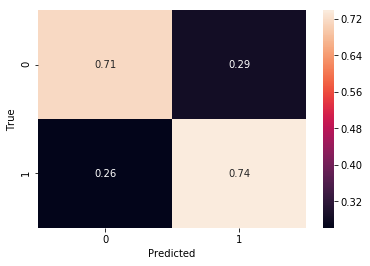

In [4]:
def get_predictions(estimator, input_fn):
  return [x["class_ids"][0] for x in estimator.predict(input_fn=input_fn)]

LABELS = [
    0, 1
]

# Create a confusion matrix on training data.
with tf.Graph().as_default():
  cm = tf.confusion_matrix(df[train_length:]["label"], 
                           get_predictions(estimator, predict_test_input_fn))
  with tf.Session() as session:
    cm_out = session.run(cm)

# Normalize the confusion matrix so that each row sums to 1.
cm_out = cm_out.astype(float) / cm_out.sum(axis=1)[:, np.newaxis]

sns.heatmap(cm_out, annot=True, xticklabels=LABELS, yticklabels=LABELS);
plt.xlabel("Predicted");
plt.ylabel("True");